In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import pickle

In [2]:
df_customer = pd.read_csv('data/18_Customer_data.csv', encoding='cp949')
print(df_customer.shape)
df_customer.head(2)

(6863, 26)


Unnamed: 0     고객ID  성별  연령 결혼여부 부양자유무  부양자수  추천횟수 영수증발급여부  과금방식  ...  \
0           0  C-10001  여성  37  Yes    No     0     2     Yes  신용카드  ...   
1           1  C-10002  남성  46   No    No     0     0      No  신용카드  ...   

          종료일 고객이탈여부 이탈가능점수 이탈유형  이탈사유   LTV 만족도 데이터사용료  로밍사용료   총로밍요금  
0  2022-01-01     No     65  NaN   NaN  2205   3      0  47910  431100  
1  2022-01-01     No     66  NaN   NaN  5414   5  11300  12090  108710  

[2 rows x 26 columns]

In [3]:
df_charge = pd.read_csv('data/18_Charge_data.csv', encoding='cp949')
print(df_charge.shape)
df_charge.head(2)

(291334, 4)


Unnamed: 0     고객ID         과금일    과금액
0           0  C-10001  2020-04-01  84600
1           1  C-10001  2020-05-01  83500

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

x = df_customer[['성별', '연령', '결혼여부', '부양자수',
       '보안서비스', '백업서비스', '기술지원서비스', '데이터무제한']]
y = df_customer['고객이탈여부'].replace({'Yes':1, 'No':0}).astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

C:\Users\leedo\AppData\Local\Temp\ipykernel_20792\1004223071.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_customer['고객이탈여부'].replace({'Yes':1, 'No':0}).astype(int)


In [6]:
best_model = pickle.load(open('model_lg.sav', 'rb'))
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['연령', '부양자수'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['성별', '결혼여부', '보안서비스', '백업서비스', '기술지원서비스', '데이터무제한'], dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    solver='newton-cg'))])

In [7]:
# 평가를 수행하기 위한 예측값을 계산

Y_train_pred = best_model.predict(x_train)
Y_test_pred = best_model.predict(x_test)

In [8]:
print(classification_report(y_train, Y_train_pred))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      3615
           1       0.42      0.70      0.52      1189

    accuracy                           0.68      4804
   macro avg       0.64      0.69      0.64      4804
weighted avg       0.76      0.68      0.70      4804

              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1546
           1       0.43      0.72      0.54       513

    accuracy                           0.69      2059
   macro avg       0.65      0.70      0.65      2059
weighted avg       0.77      0.69      0.71      2059



- 로지스틱 모델 회귀 계수
- 회귀 계수의 의미: x가y에 대한 로그 odds에 어떤 영향을 미치는 지를 나타내는 지표
- 회귀 계수가 양수-> x값이 증가함에 따라 y값에 속할 확률이 증가
- 회귀 계수가 음수-> x값이 증가함에 따라 y값에 속할 확률이 감소

In [9]:
df_coef = pd.DataFrame()
df_coef['회귀계수'] = best_model['logisticregression'].coef_[0]

In [13]:
df_coef['변수명'] = best_model['columntransformer'].get_feature_names_out()

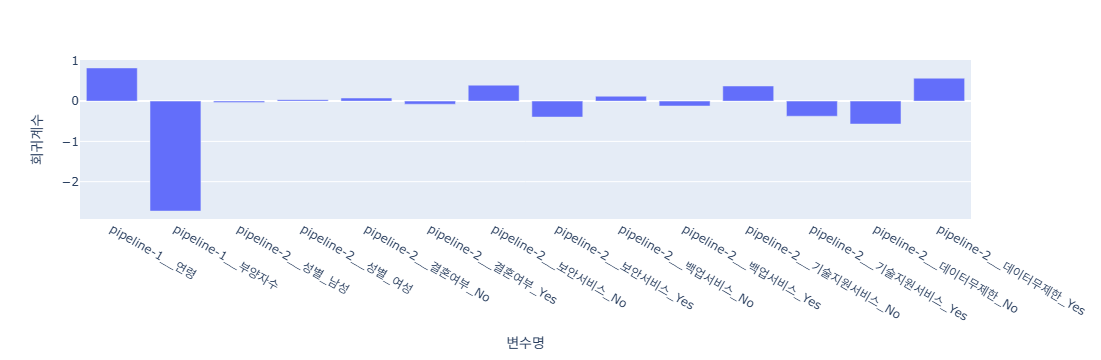

In [14]:
px.bar(df_coef, x = '변수명', y = '회귀계수')

In [15]:
# 5. 두 데이터를 활용해 한 명의 고객이 결제한 총 결제금액을 고객 ID 별로 정리하고, 한 명의 고객 금액, 과금 빈도, 최근성등을 이용해, RFM 분석을 실시해 RFM Score를 계산하고, 고객을 5등급으로 (20%씩) 분류하시오.
#    - 금액은 0.5 / 빈도는 기간 내 전체 빈도로 0.3 / 최근성은 -0.2 가중치 부여
#    - 최근성은 한명의 고객의 마지막 과금일을 기준으로 계산

df_charge['과금일_dt'] = pd.to_datetime(df_charge['과금일'])
df_charge['과금일_dt'].describe()

count                           291334
mean     2019-06-17 11:01:12.634159104
min                2015-01-01 00:00:00
25%                2018-03-01 00:00:00
50%                2019-10-01 00:00:00
75%                2020-12-01 00:00:00
max                2021-12-01 00:00:00
Name: 과금일_dt, dtype: object

In [16]:
df_charge['R'] = max(df_charge['과금일_dt']) - df_charge['과금일_dt']
df_charge.head(2)

Unnamed: 0     고객ID         과금일    과금액     과금일_dt        R
0           0  C-10001  2020-04-01  84600 2020-04-01 609 days
1           1  C-10001  2020-05-01  83500 2020-05-01 579 days

In [17]:
p0 = df_charge.pivot_table(index = '고객ID', values='R', aggfunc='min').reset_index()
p0.shape

(6863, 2)

In [18]:
p0['R_int'] = p0['R'].dt.days
p0['R_int'].describe()

count    6863.000000
mean       40.876585
std        88.388811
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       334.000000
Name: R_int, dtype: float64

In [19]:
df_charge['F'] = 1
p1 = df_charge.pivot_table(index = ['고객ID'], values='F', aggfunc='sum').reset_index()
p1.head(2)

고객ID   F
0  C-10001  21
1  C-10002  21

In [20]:
p2 = df_charge.pivot_table(index = '고객ID', values='과금액', aggfunc='sum').reset_index()
p2.head(2)

고객ID      과금액
0  C-10001  1755400
1  C-10002  1447500

In [21]:
m1 = pd.merge(p0, p1, on = '고객ID', how = 'inner')
m2 = pd.merge(m1, p2, on = '고객ID', how = 'inner')
m2.shape

(6863, 5)

In [22]:
# score 계산 수행
# -0.2 * 최근성 + 0.3 * 빈도수 + 0.5 * 금액
m2['T'] = m2['R_int'] * -0.2 + m2['F'] * 0.3 + m2['과금액'] * 0.5
m2['T'].describe()

count    6.863000e+03
mean     1.711950e+06
std      1.504281e+06
min      2.113380e+04
25%      4.884807e+05
50%      1.155407e+06
75%      2.741240e+06
max      5.837575e+06
Name: T, dtype: float64

In [26]:
dic = {1:'D', 2:'C', 3:'B', 4:'A'}

m2['고객등급'] = 'E'
for i in range(1, 5):
    m2.loc[m2['T'] >= m2['T'].quantile(0.2 * i), '고객등급'] = dic[i]

m2['고객등급'].value_counts()

고객등급
C    1373
E    1373
A    1373
D    1372
B    1372
Name: count, dtype: int64

In [28]:
# 6. 5등급으로 부여된 고객 등급 별 고객 연령대의 비율이 어떻게 달라지는지 계산하시오.
df1 = pd.merge(df_customer, m2, on = '고객ID', how = 'inner')
print(df1.shape)
df1.head(2)

(6863, 32)


Unnamed: 0     고객ID  성별  연령 결혼여부 부양자유무  부양자수  추천횟수 영수증발급여부  과금방식  ... 만족도  \
0           0  C-10001  여성  37  Yes    No     0     2     Yes  신용카드  ...   3   
1           1  C-10002  남성  46   No    No     0     0      No  신용카드  ...   5   

  데이터사용료  로밍사용료   총로밍요금      R R_int   F      과금액         T 고객등급  
0      0  47910  431100 0 days     0  21  1755400  877706.3    C  
1  11300  12090  108710 0 days     0  21  1447500  723756.3    D  

[2 rows x 32 columns]

In [29]:
def func1(row):
    if pd.isnull(row):
        return row
    return str(row)[0] + '0대'

df1['연령대'] = df1['연령'].apply(func1)
df1['연령대'].value_counts()

연령대
20대    1344
40대    1308
30대    1258
50대    1217
60대     982
70대     691
80대      63
Name: count, dtype: int64

In [30]:
c1 = pd.crosstab(df1['고객등급'], df1['연령대'], margins= True)
for i in c1.columns[:-1]:
    c1[i + '_ratio'] = c1[i]/c1['All']

c1[[x for x in c1.columns if 'ratio' in x]]

연령대   20대_ratio  30대_ratio  40대_ratio  50대_ratio  60대_ratio  70대_ratio  \
고객등급                                                                     
A      0.187181   0.186453   0.176985   0.168245   0.142025   0.128186   
B      0.194606   0.163994   0.168367   0.172741   0.155248   0.133382   
C      0.198106   0.169701   0.185725   0.193736   0.145666   0.094683   
D      0.197522   0.191691   0.212828   0.169096   0.148688   0.077259   
E      0.201748   0.204661   0.209031   0.182811   0.123816   0.069920   
All    0.195833   0.183302   0.190587   0.177328   0.143086   0.100685   

연령대   80대_ratio  
고객등급             
A      0.010925  
B      0.011662  
C      0.012382  
D      0.002915  
E      0.008012  
All    0.009180

In [31]:
# 7. 각 고객 등급 중에 데이터 사용료의 평균이 가 가장 높은 집단은 어디인가? 
df1.pivot_table(index = '고객등급', values='데이터사용료', aggfunc='mean').sort_values(by = '데이터사용료', ascending=False)

데이터사용료
고객등급              
B     13169.606414
A     11316.460306
C      7999.708667
D      5205.247813
E      1892.935178

In [34]:
# 8. 각 고객 등급 중에 가장 최근(150일 이내)에 가입한 고객의 비율이 많은 집단은 어디인가?

df1['가입기간'] = max(pd.to_datetime(df1['시작일'])) - pd.to_datetime(df1['시작일'])
df1.loc[df1['가입기간'].dt.days <= 150, '신규고객'] = 1
df1.loc[~(df1['가입기간'].dt.days <= 150), '신규고객'] = 0
df1['신규고객'].value_counts()

신규고객
0.0    6640
1.0     223
Name: count, dtype: int64

In [39]:
p3 = df1.pivot_table(index = '고객등급', values='신규고객', aggfunc=['sum', 'count'])
p3.columns = ['신규고객수', '전체고객수']
(p3['신규고객수'] / p3['전체고객수']).sort_values(ascending=False)

고객등급
E    0.162418
A    0.000000
B    0.000000
C    0.000000
D    0.000000
dtype: float64

In [40]:
# 9. 각 고객 등급 중에 데이터 사용료 평균의 차이가 가장 큰 두 등급은 어디인가?

p4 = df1.pivot_table(index = '고객등급', values='데이터사용료', aggfunc='mean').sort_values(by = '데이터사용료', ascending=False)
p4['데이터사용료'].head(1).values - p4['데이터사용료'].tail(1).values

array([11276.67123555])

### 결정트리 알고리즘

- 결정 트리는 트리 구조를 따라 데이터 포인트를 점진적으로 분할 하면서 예측을 수행
- 각 노드는 특정 특징에 대한 조건을 기준으로 데이터를 분할하고, 이 과정을 반복하면서 잎 노드에 도달하면 최종 예측을 수행
- 결정 트리의 핵심 목표는 최대한 잘 데이터를 분리하는 것이며, 이를 위해 특정 분할 기준을 통해 트리의 각 분기점에서(node) 데이터를 나눔
- 분할 기준은 각 특징이 데이터를 얼마나 잘 나누는지 (y를 얼마나 잘 예측, 분류) 병가하여 결정하게 되며, 여기서 평가 함수를 특정 최적화 함수로 사용하는 것에 따라 tree 알고리즘의 기법이 달라진다.
- 결정트리 알고리즘의 종류
  1. ID3 (iterative dichotomiser 3)
     - ID3는 결정트리 알고리즘의 초기형태로, 정보이득(information gain)을 기준으로 데이터를 분할
     - 정보이득: 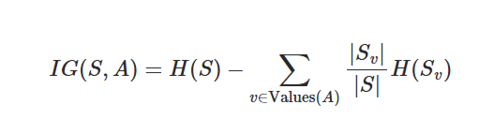
     - 데이터 분할 시 엔트로피개념을 이용해, 각 특징이 얼마나 잘 데이터를 분할하는지 평가
     - 엔트로피: 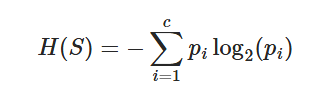
     - pi: 특정 사건이 발생할 확률
     - 알고리즘이 간단하고 구현하기 쉬우나, 연속형 변수를 처리하지 못하고, 과적합 발생확률이 높음
     - 다지분할
  2. cart(classification and regression tree)
     - 분류와 회귀 모두 수행 가능한 대표적인 결정 트리 알고리즘
     - 각 node에서 이진분할을 통해, 데이터를 두 그룹으로 분할 하면서 학습
     - 분류 문제에서는 지니 불순도 또는 정보이득
     - 회귀 문제에서는 분산을 최소화 하는 방향으로 분할
     - 과적함의 발생 활률이 매우 높아 hyperparameter tuning 필수적
  3. c4.5
     - id3 알고리즘을 개선한 형태
     - 분류문제에서 사용되는 트리, 정보이득 비율을 이용해 데이터를 분할
     - 다지 분할(multi-way splits)이 가능하며 연속형 데이터 처리 가능
     - 대신 계산소요가 매우 크다
  4. chaid(chi-squared automatic interaction detection)
     - 카이 제곱 검정기법을 활용해 데이터를 분할하는 결정 트리 알고리즘
     - 다지분할이 가능하며, 분할 시 x와 y간 연관성을 추정할 수 있음
     - 범주형 데이터에 대해 매우 효과적, 다지분할을 통해 트리구조가 비교적 덜 복잡해짐
     - 연속형 자료 처리 불가

### cart

- 장점:
  - 분류, 회귀에서 모두 사용할 수 있는 알고리즘
  - 대용량 데이터에 대해서 잘 작동
  - 비모수 데이터에 대해 잘 작동(비모수: 통계적인 가정을 따르지 않는 데이터 -> 정규분포가 아님, 이상치)
  - 이상치를 제거하거나 데이터의 분포를 바꾸거나 하는등의 데이터 핸들링을 하지 않아도 잘 작동
- 단점:
  - 과적합이 매우 잘 발생한다(분할 기준을 모든 데이터가 분류될 때 까지 생성하는 식으로 작동)
  - 분류 경계에서 오류 가능성이 매우 높음
- tree 구조
  - node: 데이터를 특정 기준에 따라 분할하는 지점
  - splitting criteria 분할 기준: 데이터를 가장 잘 나누는 특징 column의 분할 기준을 찾아 하위 노드로 데이터를 분할
  - depth: 각 노드가 분할되며 발생하는 나무 구조 층
  - leaf node: 분할이 모두 끝난 뒤 더이상 분할 불가능한 가장 마지막 노드
  - branch: 루트 노드에서 마지막 노드까지의 줄기
- cart 최적화 기법
  - gini 불순도: 데이터가 얼마나 분할되어있지 않고 섞여 있는지에 대한 지표
  - entropy 무질서도: 데이터의 무질서한 정도를 나타낸 지표
  - mean square error(회귀): 회귀 트리의 손실함수를 최소제곱법으로 계산한 지표
  - log loss, ...

In [41]:
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')

In [42]:
pipe1 = make_pipeline(SimpleImputer(strategy='median'))
pipe2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
pipe1_list = x.describe().columns
pipe2_list = x.describe(include='object').columns

pipe3 = make_column_transformer((pipe1, pipe1_list), (pipe2, pipe2_list))
model_pipe = make_pipeline(pipe3, DecisionTreeClassifier())

hyper = {'decisiontreeclassifier__max_depth': range(5, 10), 
         'decisiontreeclassifier__min_samples_split': range(5, 10), 
         'decisiontreeclassifier__criterion': ['gini', 'entropy'], 
         'decisiontreeclassifier__class_weight': ['balanced'], 
         }
grid_model = GridSearchCV(model_pipe, param_grid=hyper, cv = 3, scoring='f1', n_jobs=-1)
grid_model.fit(x_train, y_train)
best_model = grid_model.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['연령', '부양자수'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['성별', '결혼여부', '보안서비스', '백업서비스', '기술지원서비스', '데이터무제한'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=5))])

**Tree Model HyperParameter**
- criterion (default='gini'): 노드의 분할 기준을 선택하는 데 사용되는 최적화 함수
- splitter (default='best'): 각 노드에서 데이터를 분할하는 데 사용되는 전략 'best'는 최적의 분할을 찾으려고 시도, 'random'은 무작위 분할을 시도
- **max_depth (default=None)**: 트리의 최대 깊이를 제한. 이 매개변수를 사용하여 과적합을 방지. None으로 설정하면 최대한 깊게 분할.
- **min_samples_split (default=2)**: 노드를 분할하기 위해 필요한 최소 샘플 수. 이 값보다 작으면 더 이상 분할하지 않음.
- min_samples_leaf (default=1): 리프 노드가 가져야 하는 최소 샘플 수. 이 값보다 작은 리프 노드가 생성되지 않음.
- min_weight_fraction_leaf (default=0.0): 리프 노드에 필요한 샘플의 가중치 합의 최소 가중치 비율.
- max_features (default=None): 각 분할에서 고려할 최대 특성 수. None으로 설정하면 모든 특성을 고려.
- max_leaf_nodes (default=None): 리프 노드의 최대 개수를 제한. None으로 설정하면 제한이 없음.
- min_impurity_decrease (default=0.0): 분할하기 위한 최소 불순도 감소를 나타내는 임계값. 이 값을 기준으로 노드가 분할.
- **class_weight (default=None)**: 클래스 가중치를 지정하는데 사용. 클래스 불균형이 있는 경우 모델의 성능을 높이기 위해 사용될 수 있음.
- ccp_alpha (default=0.0): 가지치기에 사용되는 복잡성 비용 별도의 매개변수. 가지치기는 트리의 일부를 제거하여 모델을 단순화하고 일반화 성능을 향상.

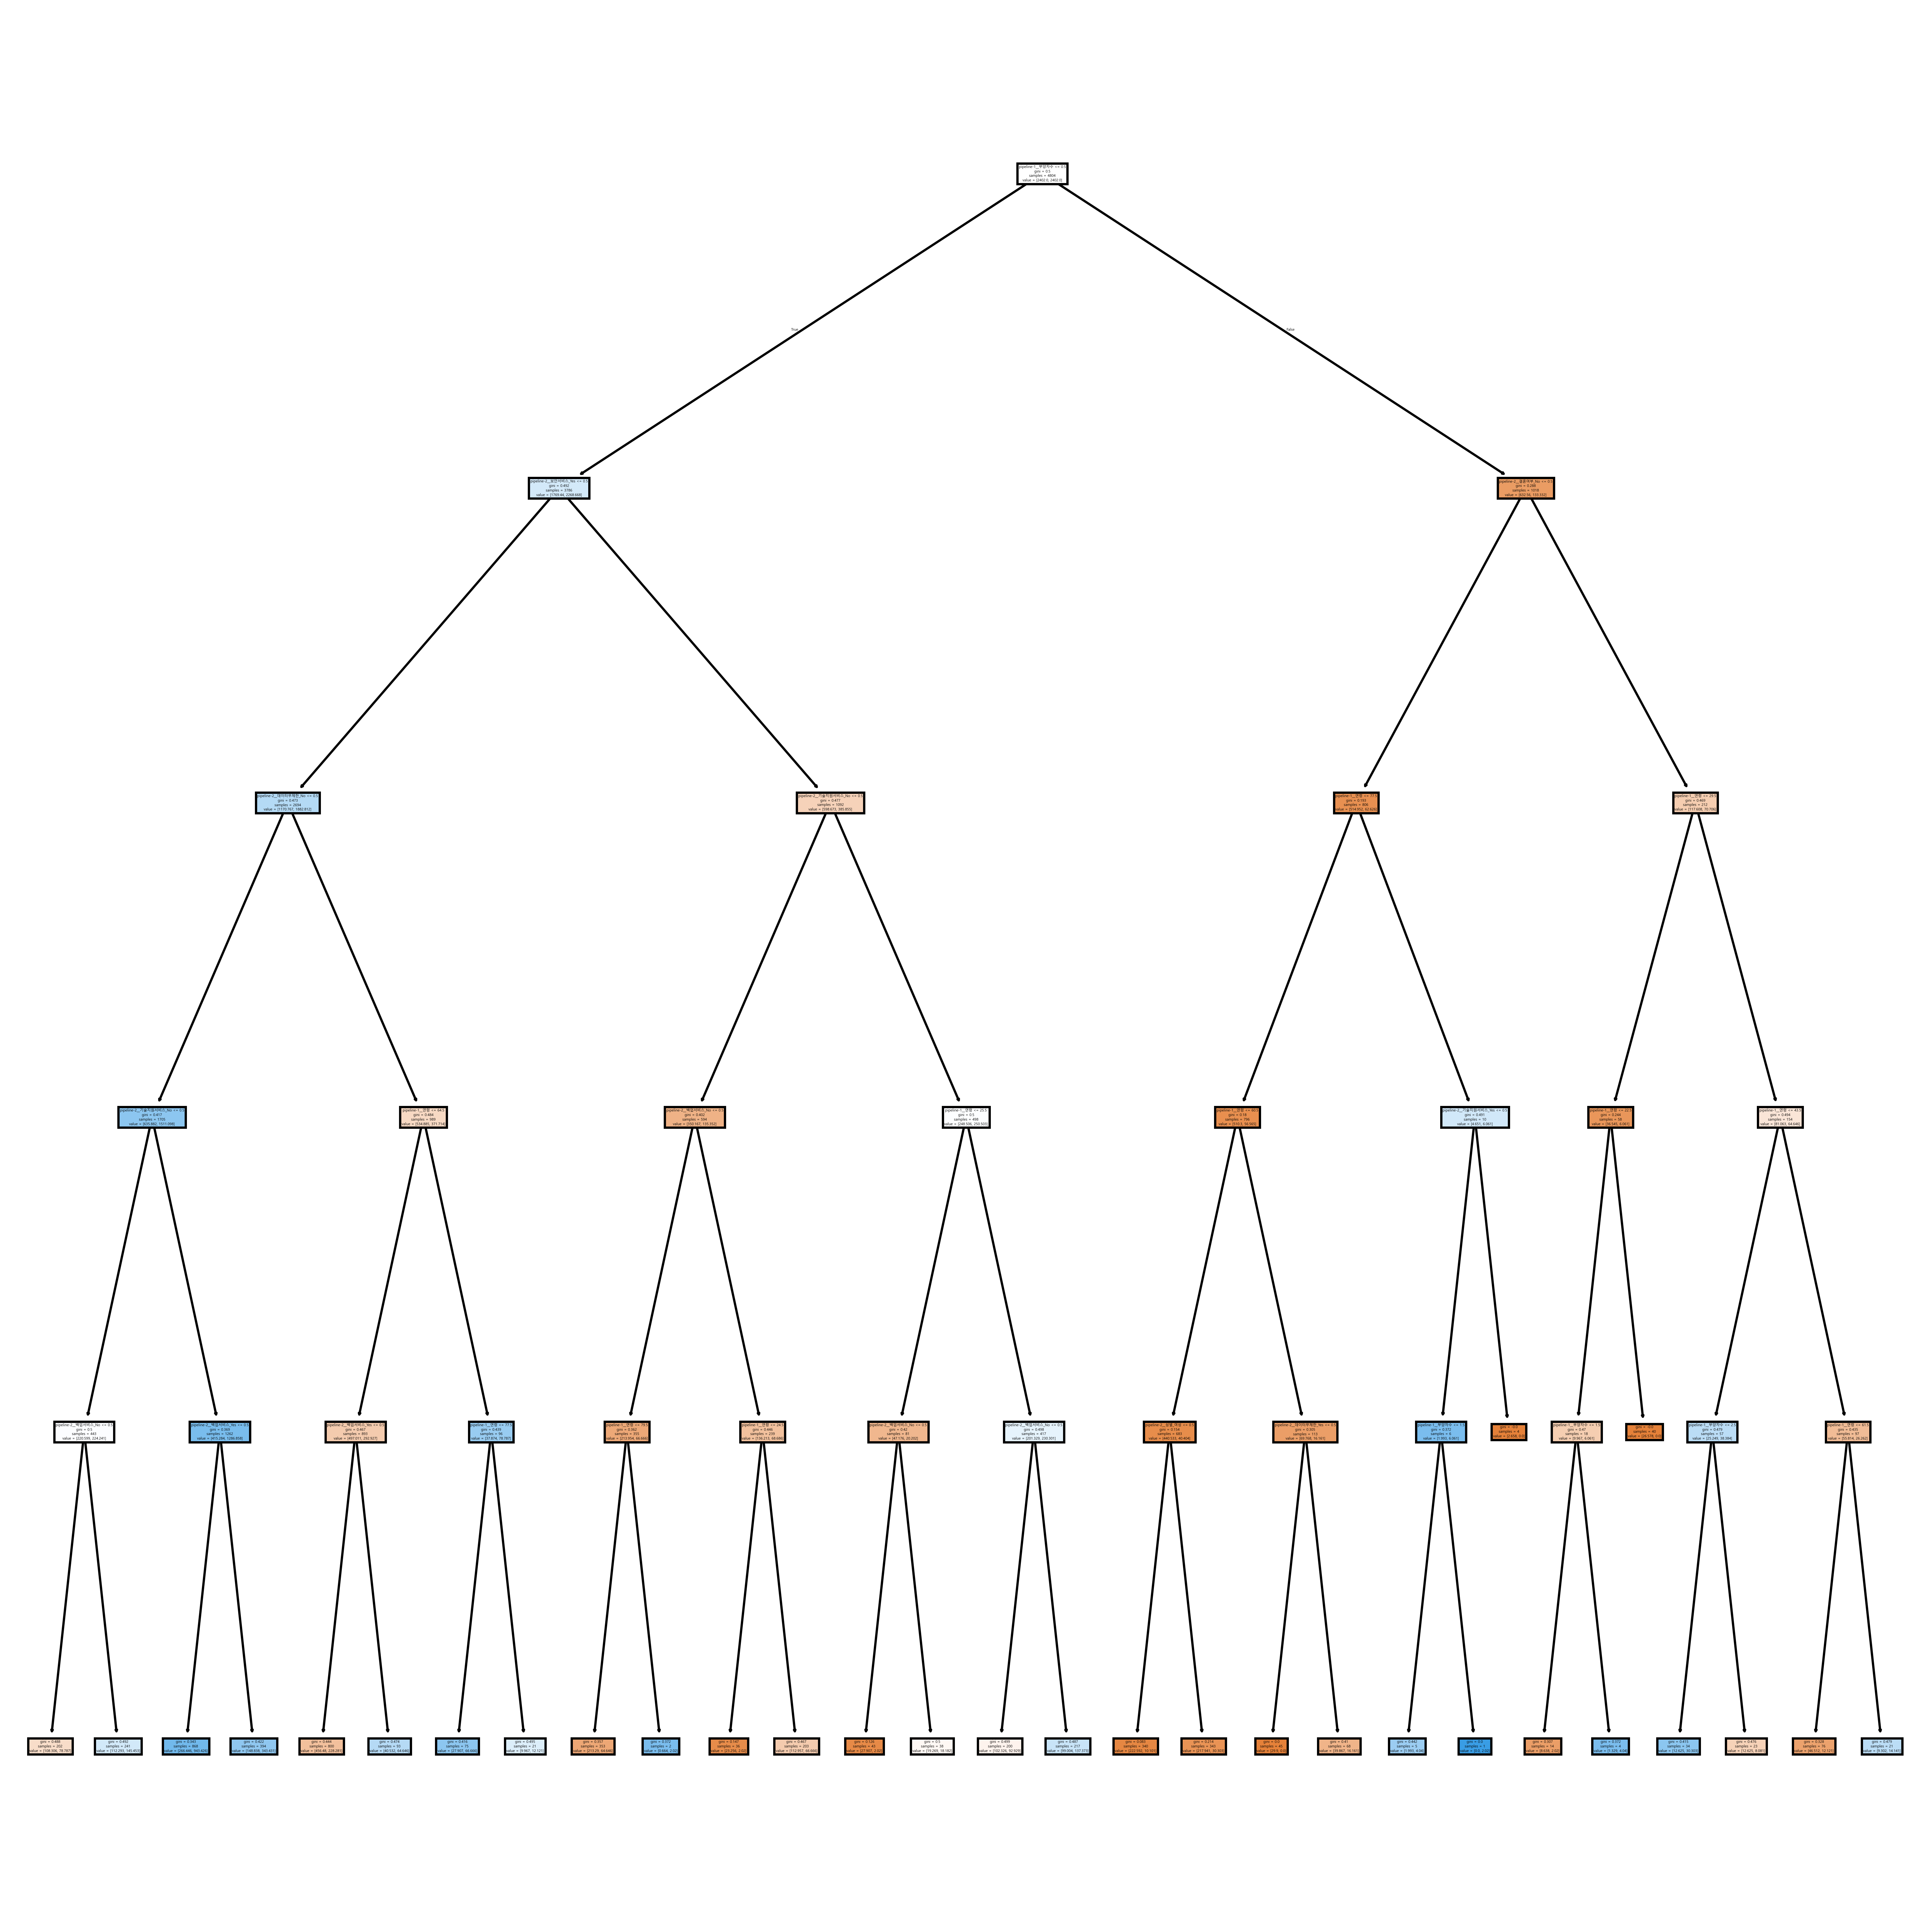

In [46]:
plt.figure(figsize=[15, 15], dpi = 500)
plot_tree(best_model['decisiontreeclassifier'], filled = True, feature_names=best_model['columntransformer'].get_feature_names_out())
plt.savefig('tree.png')